```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018, 2019 Norwegian Meteorological Institute

This notebook implements the experiments to evaluate convergence rates
for the four numerical schemes, as reported in Section 4.7 in 
"Evaluation of Selected Finite-Difference and Finite-Volume Approaches
to Rotational Shallow-Water Flow"  by Holm, Brodtkorb, Broström, 
Christensen and Sætra. 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Numerical Order - nontrivial parameters


## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc, colors, cm
from matplotlib import pyplot as plt

import os
import datetime
import gc
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(6.0, 4.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%setup_logging -o compareschemes2d.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger using level DEBUG to compareschemes2d.log
Python version 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Registering gpu_ctx in user workspace
PyCUDA version 2019.1.2
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <94117915280576>


In [3]:
#Create output directory for images
imgdir='images_convergence_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving images to " + imgdir)

Saving images to images_convergence_2019_11_05-20_42_12


In [4]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

8.092556560821176 -6.541861464796368


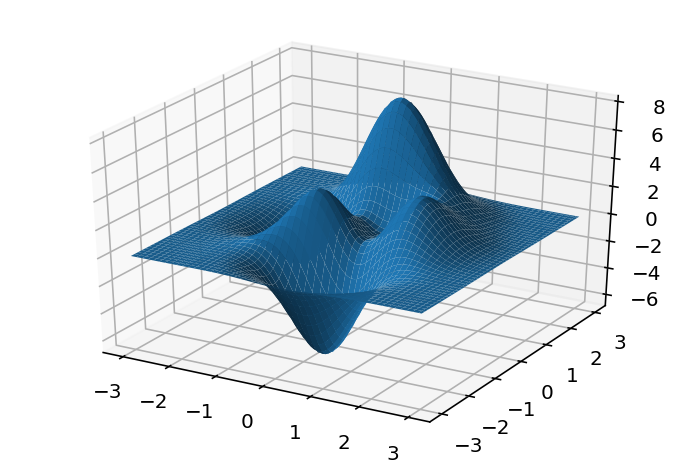

In [5]:
def peaks(nx, ny):
    x = np.linspace(-3, 3, nx)
    y = np.linspace(-3, 3, ny)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2*np.exp(-(x**2) - (y+1)**2) - 10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3*np.exp(-(x+1)**2-y**2)
    return x, y, z


from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = peaks(100, 100)
ax.plot_surface(x, y, z)

print(np.max(z), np.min(z))

In [6]:
width = 500000
height = 500000

domain_min = 16
domain_max = 1024
    
g = 9.81
r = 0.00
f = 1.0e-4
beta = 1.0e-11

end_time = 1600.0

In [7]:
def averageFV(highres_solution, factor):
    NX = highres_solution.shape[1]
    NY = highres_solution.shape[0]
    
    assert(NY % factor == 0)
    assert(NX % factor == 0)
    
    nx = int(NX / factor)
    ny = int(NY / factor)
    
    factor = int(factor)
    
    return  highres_solution.reshape([ny, factor, nx, factor]).mean(3).mean(1)


def averageFD(highres_solution, factor):
    target = highres_solution.shape[0] / factor
    while (highres_solution.shape[0] > target):
        highres_solution = highres_solution[::2, ::2]
    return highres_solution

FV: Max=0.93095, min=0.00000, sum=0.0840758905
FV: Max=0.98230, min=0.00000, sum=0.0840758905
FV: Max=0.99555, min=0.00000, sum=0.0840758830
FV: Max=0.99889, min=0.00000, sum=0.0840758905
FV: Max=0.99973, min=0.00000, sum=0.0840758899
FD: Max=180.07443, min=38.25655, sum=130.1284942627
FD: Max=180.07443, min=35.06200, sum=116.4844741821
FD: Max=181.00496, min=34.83751, sum=109.9551086426
FD: Max=181.00496, min=34.52876, sum=106.7635955811
FD: Max=181.04521, min=34.50712, sum=105.1861203489
Angle: Max=0.98279, min=-0.46365, sum=0.2412161509
Angle: Max=0.98279, min=-0.46365, sum=0.2416571482
Angle: Max=0.98279, min=-0.46365, sum=0.2418540942
Angle: Max=0.98279, min=-0.46365, sum=0.2419472423
Angle: Max=0.98279, min=-0.46365, sum=0.2419925496


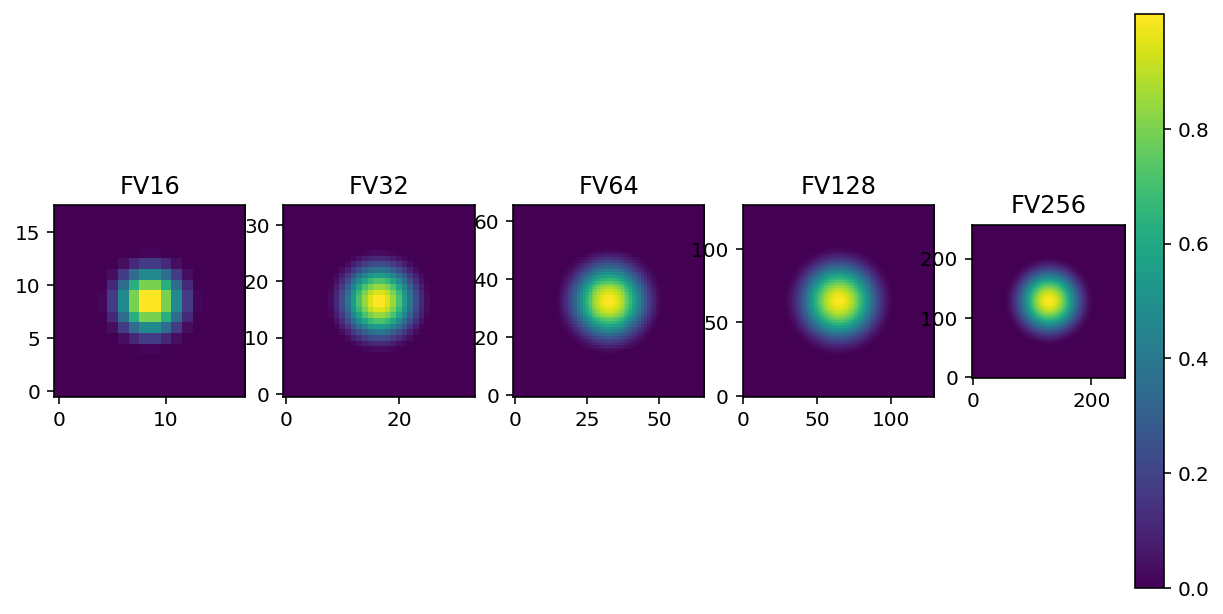

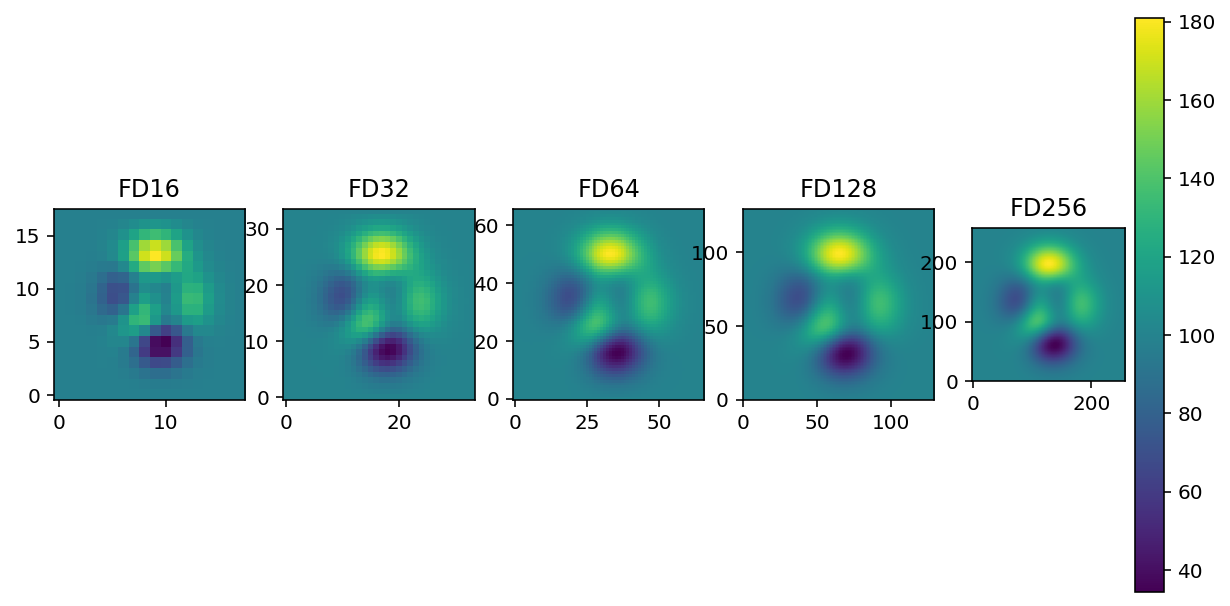

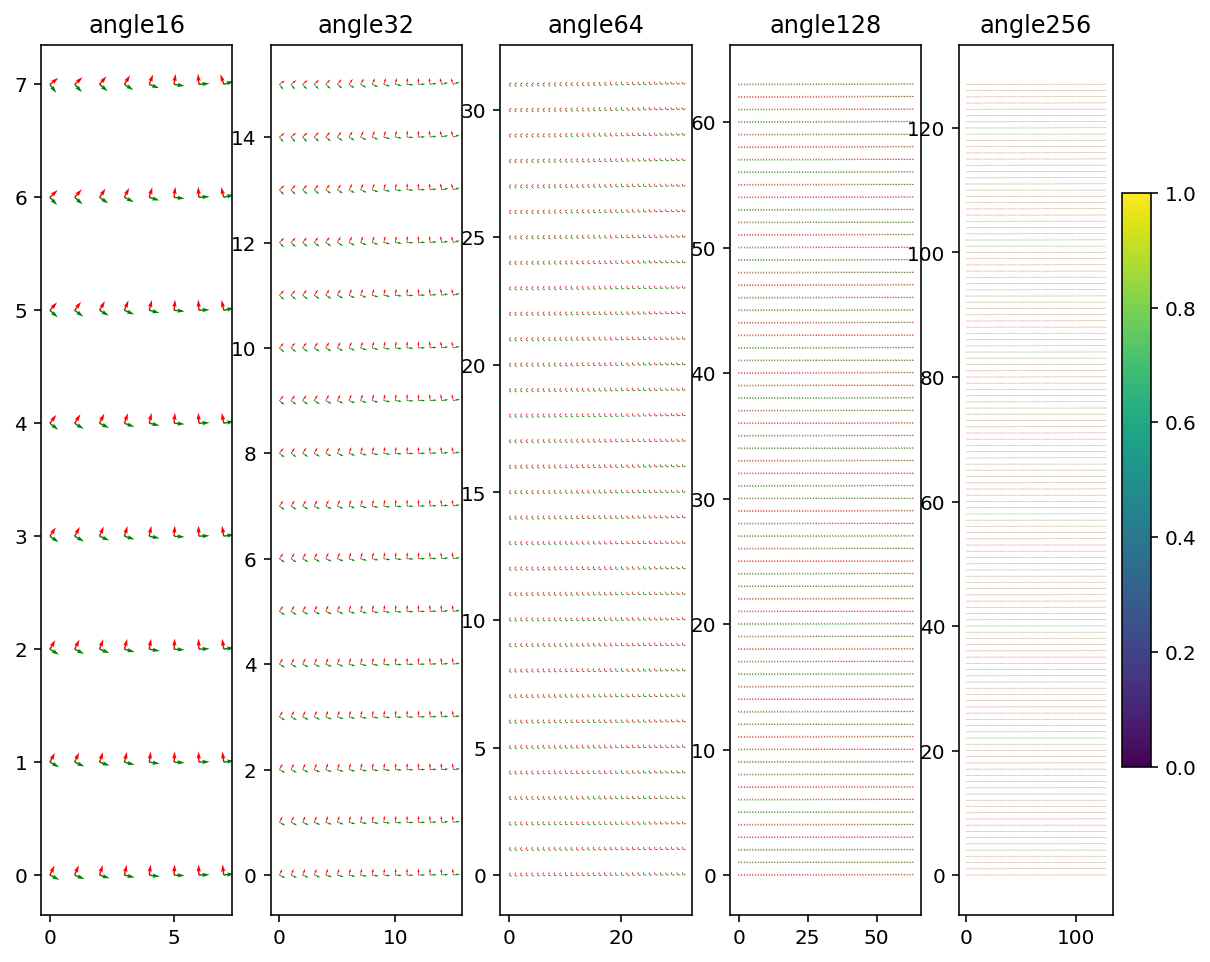

In [8]:
def initH(h0, ghosts, reference_domain_size):    
    ref_nx = reference_domain_size
    ref_ny = reference_domain_size
    nx = h0.shape[1] - ghosts[0] - ghosts[2]
    ny = h0.shape[0] - ghosts[1] - ghosts[3]
    
    _, _, z = peaks(ref_nx, ref_ny)
    z = averageFD(z, ref_nx/nx)
    h0.fill(100.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    h0[y0:y1, x0:x1] = h0[y0:y1, x0:x1] + z*10
    
    return h0
    
x = np.zeros((8, 8))
initH(x, [0, 0, 0, 0], 64)
    
def initAngle(angle):
    ny, nx = angle.shape
    
    #North pole
    x0 = 0.5
    y0 = 2.0
    
    #Vector to north
    x = np.linspace(-1, 1, nx) - x0
    y = np.linspace(-1, 1, ny) - y0
    x, y = np.meshgrid(x, y)
    
    #Normalize
    l = np.sqrt(x**2 + y**2)
    x = x/l
    y = y/l
    
    angle.fill(-np.pi/2)
    angle = angle + np.arccos(x)
    
    return angle
    
    
def initEtaFV(eta0, ghosts, reference_domain_size):
    ref_nx = reference_domain_size
    ref_ny = reference_domain_size
    nx = eta0.shape[1] - ghosts[0] - ghosts[2]
    ny = eta0.shape[0] - ghosts[1] - ghosts[3]
    
    def my_cos(i, j):
        size = 0.6
        x = 2*(i + 0.5 - ref_nx/2.0) / float(ref_nx)
        y = 2*(j + 0.5 - ref_ny/2.0) / float(ref_ny)
        r = np.sqrt(x**2 + y**2)
        return (1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    #Generate disturbance 
    disturbance = np.fromfunction(lambda i, j: my_cos(i,j), (ref_ny, ref_nx))
    disturbance = averageFV(disturbance, ref_nx/nx) 
    
    eta0.fill(0.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    eta0[y0:y1, x0:x1] += (0.5*disturbance)
    
    #Make sure solution is symmetric
    eta0 = 0.5*(eta0 +  eta0[::-1, ::-1])
    

    
def initHU(hu0, ghosts):
    hu0.fill(0.0)
    
def initHV(hv0, ghosts):
    hv0.fill(0.0)

def testInitDataFV(domain_size, reference_domain_size):
    nx = domain_size
    ny = domain_size
    ghosts = [1, 1, 1, 1] 
    dataShape = (ny + ghosts[1]+ghosts[3], 
                 nx + ghosts[0]+ghosts[2])
    eta0 = np.zeros(dataShape, dtype=np.float32);
    initEtaFV(eta0, ghosts, reference_domain_size)
    return eta0#[ghosts[1]:eta0.shape[1]+ghosts[1], ghosts[0]:eta0.shape[0]+ghosts[0]]
     
def testInitDataFD(domain_size, reference_domain_size):
    nx = domain_size
    ny = domain_size
    ghosts = [1, 1, 1, 1] 
    dataShape = (ny + ghosts[1]+ghosts[3], 
                 nx + ghosts[0]+ghosts[2])
    h0 = np.zeros(dataShape, dtype=np.float32);
    initH(h0, ghosts, reference_domain_size)
    return h0#[ghosts[1]:eta0.shape[1]+ghosts[1], ghosts[0]:eta0.shape[0]+ghosts[0]]
    
plt.figure(figsize=(12,8))
for i in range(5):
    domain_size = domain_min*2**i
    eta0 = testInitDataFV(domain_size, domain_min*2**6)
    plt.subplot(1, 6, i+1)
    plt.imshow(eta0, interpolation='nearest', origin='lower')
    plt.title("FV"+str(domain_size))
    print("FV: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta0), np.min(eta0), np.sum(eta0/(domain_size*domain_size))))
plt.colorbar()
    
plt.figure(figsize=(12,8))
for i in range(5):
    domain_size = domain_min*2**i
    h0 = testInitDataFD(domain_size, domain_min*2**6)
    plt.subplot(1, 6, i+1)
    plt.imshow(h0, interpolation='nearest', origin='lower')
    plt.title("FD"+str(domain_size))
    print("FD: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(h0), np.min(h0), np.sum(h0/(domain_size*domain_size))))
plt.colorbar()
    
    
plt.figure(figsize=(12,8))
for i in range(5):
    domain_size = domain_min*2**i
    angle = np.empty((domain_size, domain_size))
    angle = initAngle(angle)
    plt.subplot(1, 6, i+1)
    #plt.imshow(angle, interpolation='nearest', origin='lower')
    #plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8)
    plt.quiver(np.sin(angle[::2, ::2]), np.cos(angle[::2, ::2]), color='r')
    plt.quiver(np.cos(angle[::2, ::2]), -np.sin(angle[::2, ::2]), color='g')
    plt.title("angle"+str(domain_size))
    print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
plt.colorbar()
    

    

In [9]:
def plotData(eta0, u0, v0, eta1, u1, v1):
    fig, axarr = plt.subplots(2, 3, figsize=(12, 8))
    axarr[0, 0].imshow(eta0, interpolation="nearest")
    axarr[0, 1].imshow(u0, interpolation="nearest")
    axarr[0, 2].imshow(v0, interpolation="nearest")
    axarr[1, 0].imshow(eta1, interpolation="nearest")
    axarr[1, 1].imshow(u1, interpolation="nearest")
    axarr[1, 2].imshow(v1, interpolation="nearest")
    print("Eta0: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta0), np.min(eta0)))
    print("Eta1: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta1), np.min(eta1)))

In [10]:
def plotError(eta, eta_ref):
    max_eta = max(eta.max(), eta_ref.max())
    min_eta = min(eta.min(), eta_ref.min())
    
    err = eta - eta_ref
    max_err = max(abs(err.max()), abs(err.min()))
    
    ax1 = plt.subplot(1,3,1)
    plt.imshow(eta, vmax=max_eta, vmin=min_eta)
    plt.colorbar(shrink=0.9)
    ax1.set_title("Eta")

    ax2 = plt.subplot(1,3,2)
    plt.imshow(eta_ref, vmax=max_eta, vmin=min_eta)
    plt.colorbar(shrink=0.9)
    ax2.set_title("Eta ref")

    ax3 = plt.subplot(1,3,3)
    plt.imshow(err, vmax=max_err, vmin=-max_err, cmap="bwr")
    plt.colorbar(shrink=0.9)
    ax3.set_title("Error")

In [16]:
def computeError(filename, downsampler, order=1, plot=True):
    error = None
    domain_sizes = None
    with np.load(filename) as npzfile:
        #Get all domain sizes in file
        domain_sizes = np.array(list(npzfile.keys()), dtype=np.int)
        error = np.zeros(len(domain_sizes)-1)

        #Get largest domain size and remove (reference domain size)
        reference_domain_size = np.max(domain_sizes)
        domain_sizes = np.delete(domain_sizes, np.where(domain_sizes == reference_domain_size))

        #Get reference
        eta1_ref_disk = npzfile[str(reference_domain_size)].astype(np.float64)

        #Loop over all other domain sizes and compute the error
        for l, domain_size in enumerate(domain_sizes):
            #Get simulation
            eta1 = npzfile[str(domain_size)].astype(np.float64)

            #Downsample reference to simulation size
            eta1_ref = downsampler(eta1_ref_disk.copy(), reference_domain_size/domain_size)
            
            if (plot==True):
                plt.figure(figsize=(16,4))#, dpi=300)
                plotError(eta1, eta1_ref)
                plt.suptitle(filename)

            #Compute error 
            area = 1.0 / (domain_size*domain_size)
            if (order == 1):
                error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=order) * area
            elif (order == 2):
                error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=order) * np.sqrt(area)
            elif (order == np.inf):
                error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=order) 
        
    return domain_sizes, error


## CDKLM 16

Domain size=16, t=1600.000000, nt=16, eta=[-0.000004, 0.420820, Hi=[38.134552, 179.966202]


/home/andreb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: No contour levels were found within the data range.


Domain size=32, t=1600.000000, nt=32, eta=[-0.000004, 0.460299, Hi=[35.098377, 179.966202]


/home/andreb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: No contour levels were found within the data range.


Domain size=64, t=1600.000000, nt=64, eta=[-0.000005, 0.467455, Hi=[34.842125, 181.030853]


/home/andreb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: No contour levels were found within the data range.


Domain size=128, t=1600.000000, nt=128, eta=[-0.000005, 0.469686, Hi=[34.528316, 181.030853]


/home/andreb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: No contour levels were found within the data range.


Domain size=256, t=1600.000000, nt=256, eta=[-0.000011, 0.470271, Hi=[34.500393, 181.034698]


/home/andreb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: No contour levels were found within the data range.


Domain size=512, t=1600.000000, nt=512, eta=[-0.000011, 0.470431, Hi=[34.492626, 181.061584]


/home/andreb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: No contour levels were found within the data range.


Domain size=1024, t=1600.000000, nt=1024, eta=[-0.000012, 0.470471, Hi=[34.489544, 181.061584]


/home/andreb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: No contour levels were found within the data range.


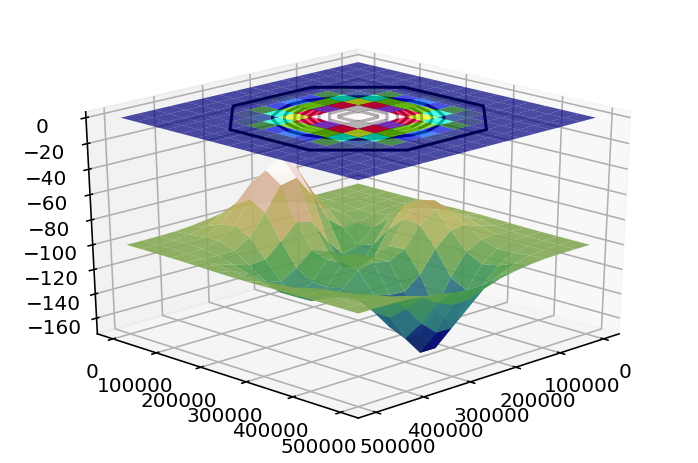

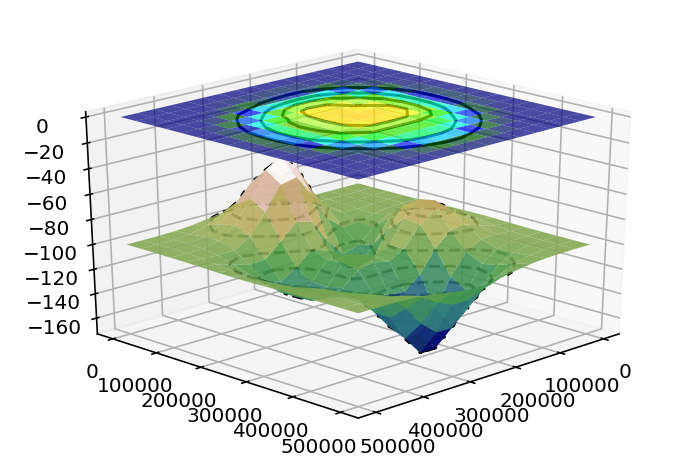

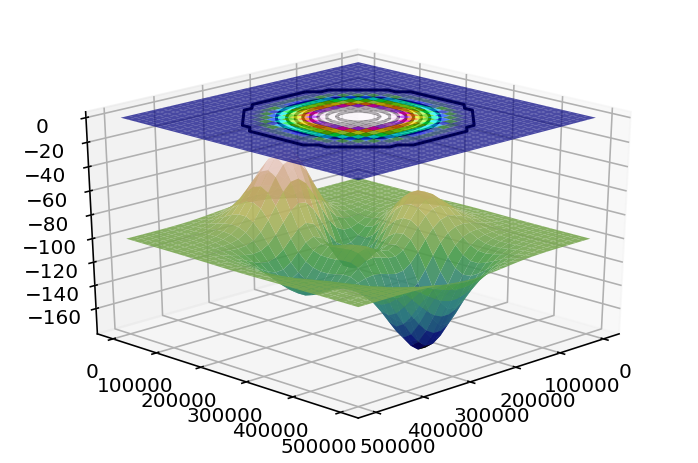

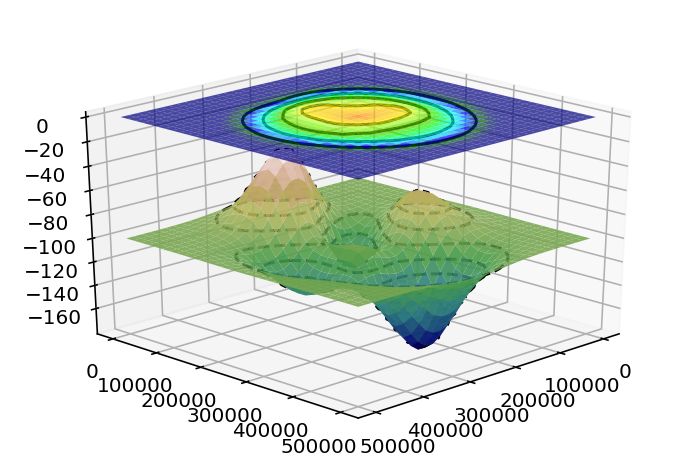

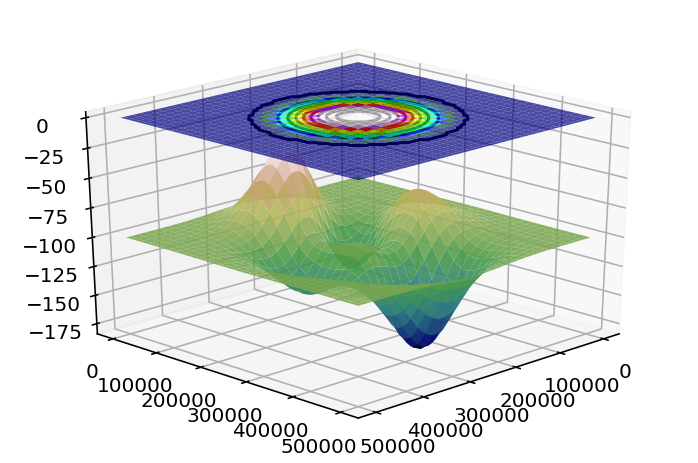

In [ ]:
def benchmarkCDKLM(cdklm_filename, plot=True):
    
    def runCDKLM(domain_size, reference_domain_size):
        #Clean up old simulator if any:
        if 'cdklm_sim' in globals():
            cdklm_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/nx)
        dy = float(height/ny)

        ghosts = np.array([2,2,2,2])
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros(dataShape, dtype=np.float32);
        hv0 = np.zeros(dataShape, dtype=np.float32);
        angle = np.zeros(dataShape, dtype=np.float32);
        
        dt = end_time / domain_size
        initH(Hi, ghosts, reference_domain_size+1)
        initEtaFV(eta0, ghosts, reference_domain_size)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)
        initAngle(angle)

        #Initialize simulator
        cdklm_sim = CDKLM16.CDKLM16(gpu_ctx, 
                      eta0, hu0, hv0, Hi, 
                      nx, ny, 
                      dx, dy, dt, 
                      g, f, r, coriolis_beta=beta,
                      angle=angle)

        t = cdklm_sim.step(end_time)
        eta1, hu1, hv1 = cdklm_sim.download()
        Hi, Hm = cdklm_sim.downloadBathymetry()
        print("Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}, Hi=[{:f}, {:f}]".format(domain_size, t, cdklm_sim.num_iterations, np.min(eta1), np.max(eta1), np.min(Hi), np.max(Hi)))
        
        if (plot==True):
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(25, 45)
            ax.pbaspect = [2.0, 2.0, 0.25]
            x = np.linspace(0, nx*dx, nx)
            y = np.linspace(0, ny*dy, ny)
            x, y = np.meshgrid(x, y)
            
            ls = colors.LightSource(270, 5)
            
            eps = 0.0
            
            ax.plot_surface(x, y, eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_ncar, edgecolor=None, shade=True, alpha=0.7, vmin=0, vmax=0.7, lightsource=ls)
            ax.contour(x, y, eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-1.0, 1.0, 20)+eps)
            
            ax.plot_surface(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_earth, edgecolor=None, shade=True, alpha=0.9, lightsource=ls)
            ax.contour(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-180, -40, 14)+eps)
            
            plt.savefig(imgdir + "/3d_" + str(nx) + ".pdf")
            
            
            
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(25, 45)
            ax.pbaspect = [2.0, 2.0, 0.25]
            x = np.linspace(0, nx*dx, nx)
            y = np.linspace(0, ny*dy, ny)
            x, y = np.meshgrid(x, y)
            
            ls = colors.LightSource(270, 5)
            
            eps = 0.0
            
            ax.plot_surface(x, y, eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_ncar, edgecolor=None, shade=True, alpha=0.7, vmin=0, vmax=0.7, lightsource=ls)
            ax.contour(x, y, eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-1.0, 1.0, 20)+eps)
            
            ax.plot_surface(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_earth, edgecolor=None, shade=True, alpha=0.9, lightsource=ls)
            ax.contour(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-180, -40, 14)+eps)
            
            plt.savefig(imgdir + "/3d_fin_" + str(nx) + ".pdf")

        return [eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {};
    domain_size = domain_min
    
    reference_domain_size = domain_min
    while (reference_domain_size <= domain_max):
        reference_domain_size *= 2
        
    while (domain_size <= domain_max):
        [_, _, _, eta1, _, _] = runCDKLM(domain_size, reference_domain_size)
        data[str(domain_size)] = eta1
        domain_size = domain_size*2

    #Save to file
    np.savez_compressed(cdklm_filename, **data)
    
    
cdklm_filename = imgdir + "/CDKLM_data.npz"
benchmarkCDKLM(cdklm_filename)

Text(0.5, 1.0, 'L1 error')

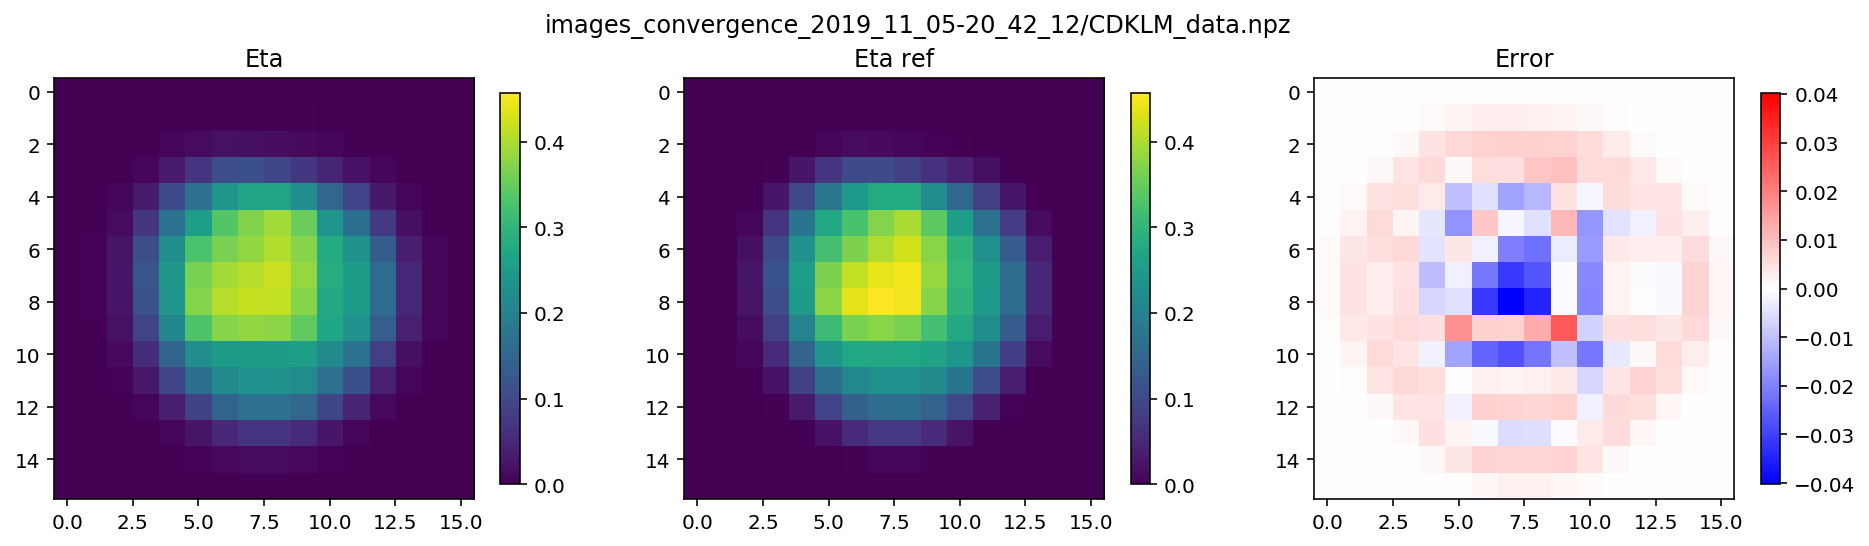

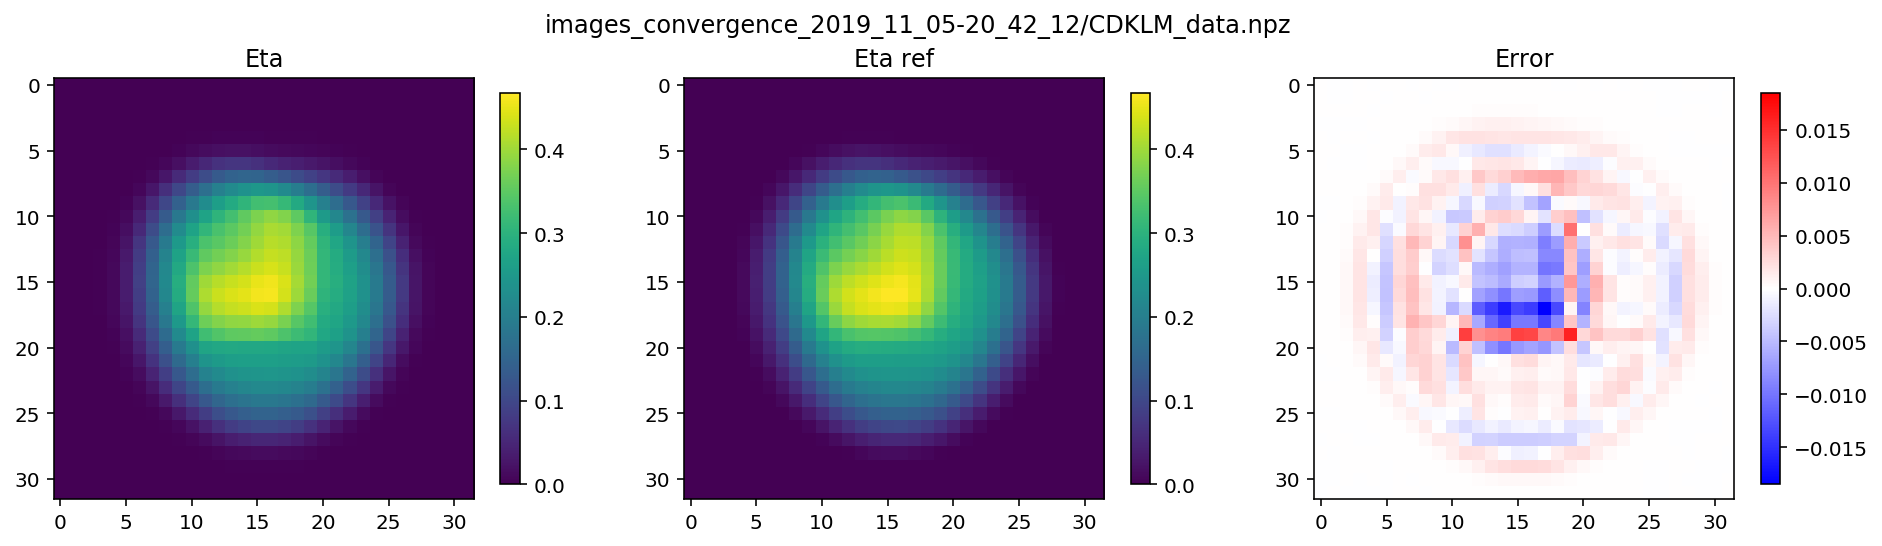

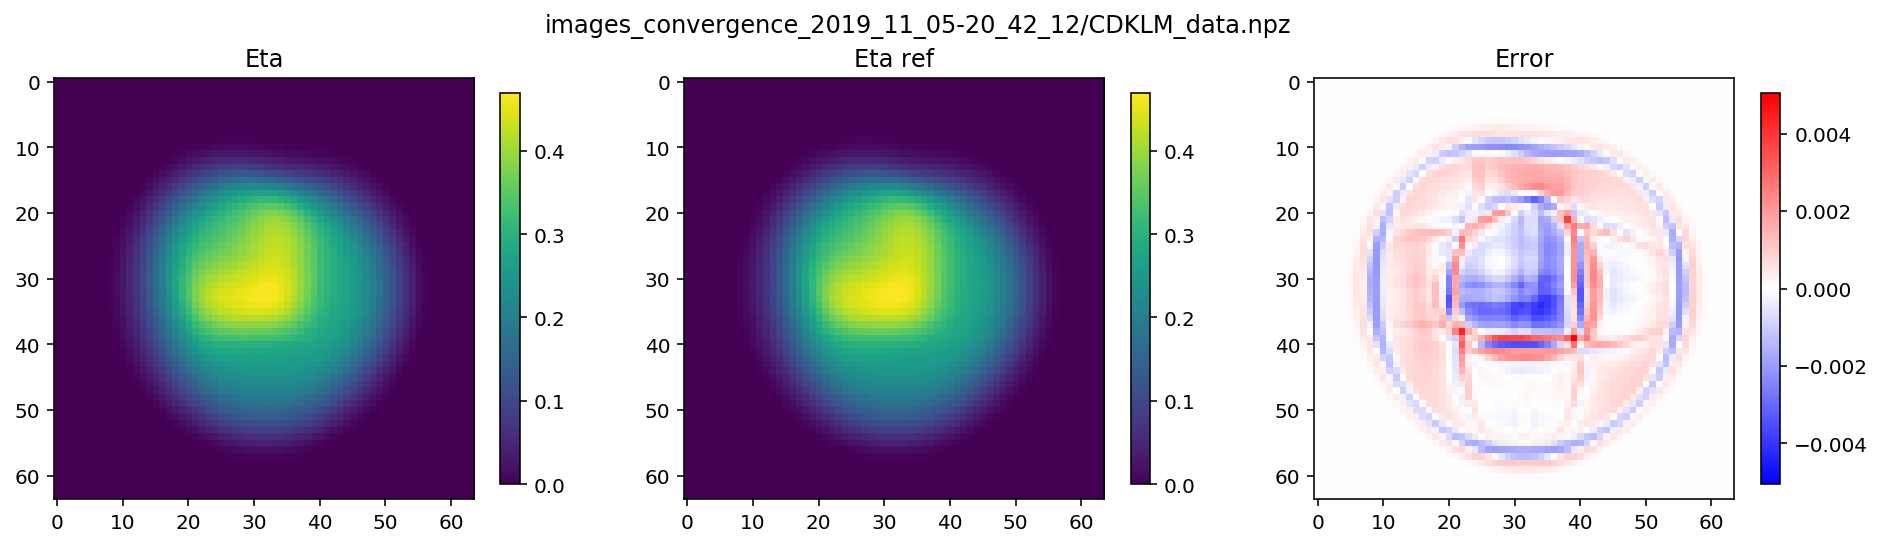

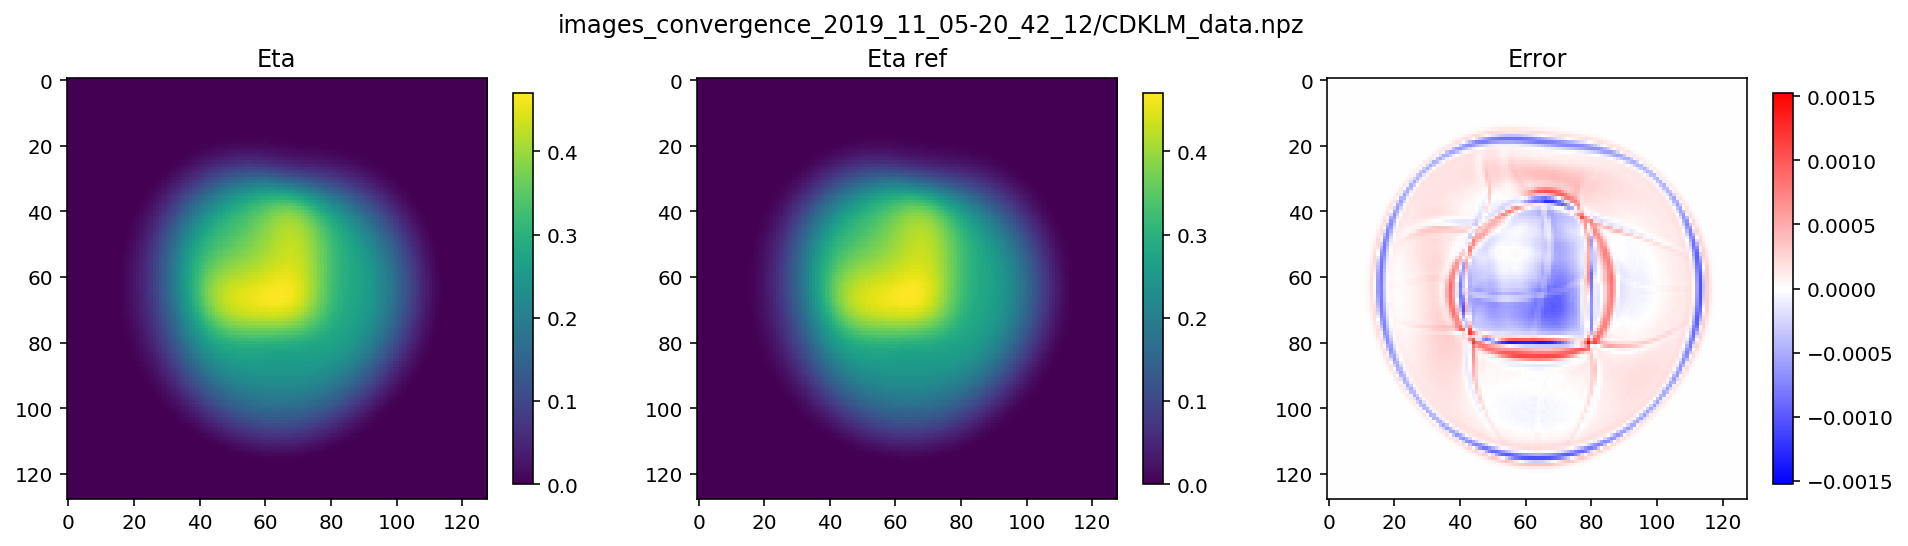

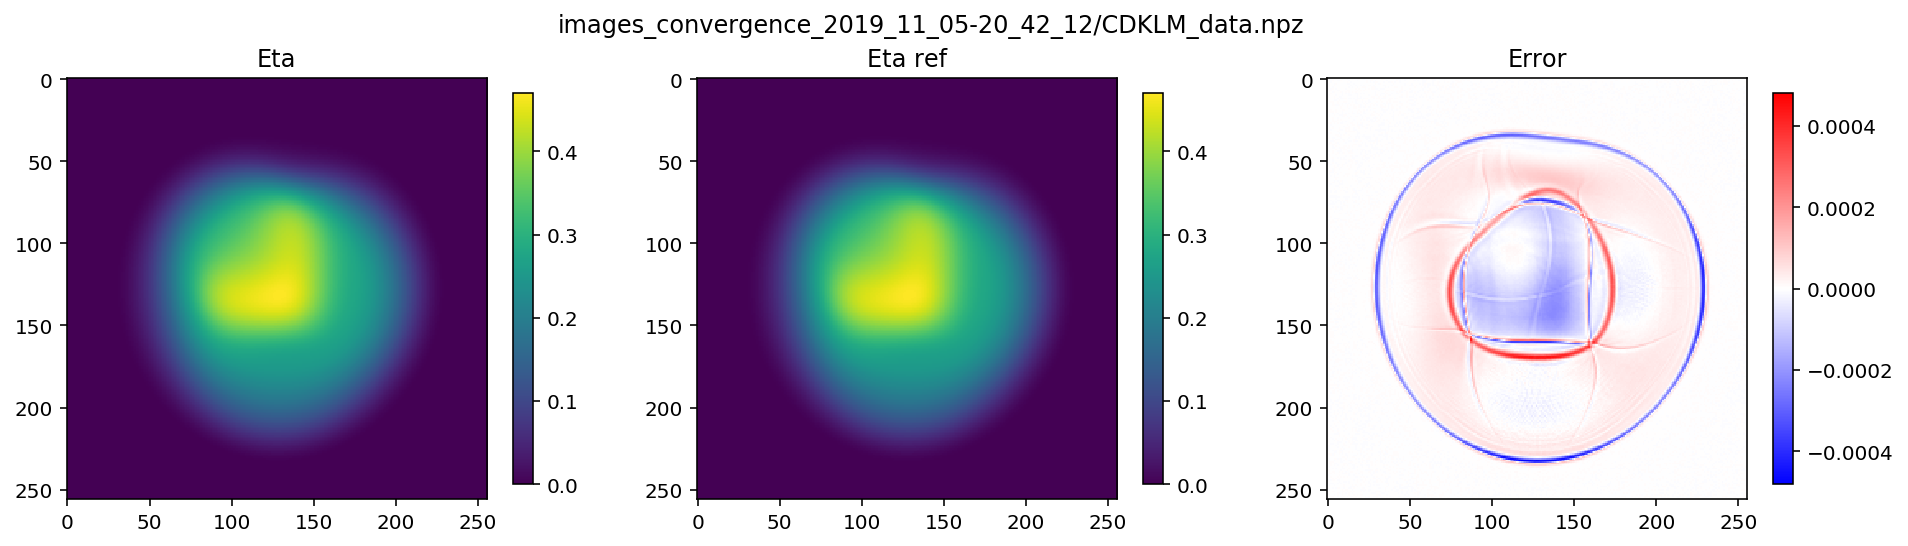

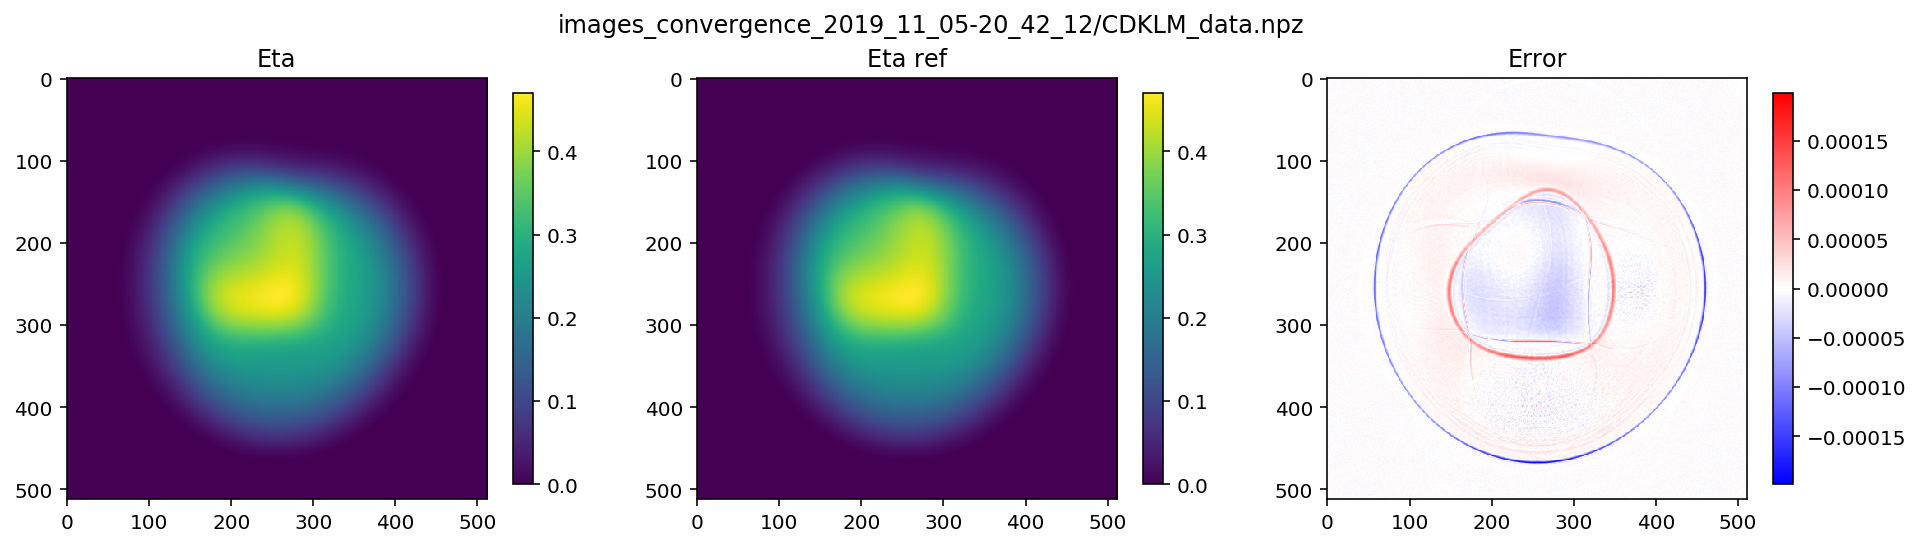

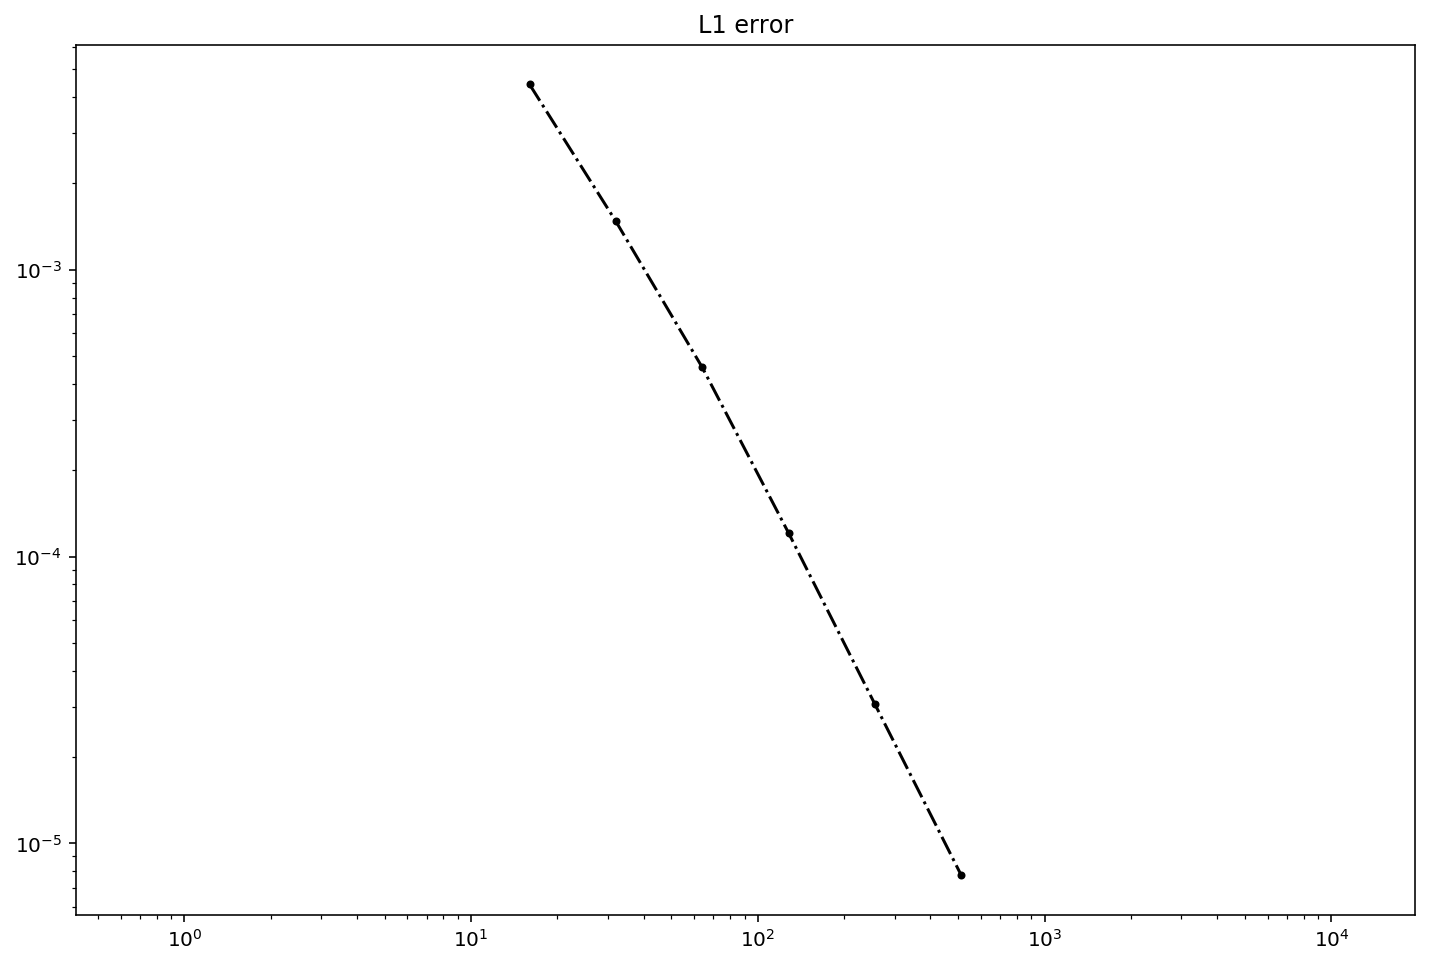

In [13]:
domain_sizes, error = computeError(cdklm_filename, averageFV, plot=True, order=1)        
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')
plt.title("L1 error")

------ order 1 ----------
CDKLM: 1.9181918263420457
------ order 2 ----------
CDKLM: 1.8553829535317135
------ order inf ----------
CDKLM: 1.6654985207900233
$16\times16$ & 0.004429 & 0.007829 & 0.040233 \\
$32\times32$ & 0.001474 & 0.002851 & 0.018507 \\
$64\times64$ & 0.000457 & 0.000837 & 0.005053 \\
$128\times128$ & 0.000121 & 0.000231 & 0.001525 \\
$256\times256$ & 0.000031 & 0.000063 & 0.000481 \\
$512\times512$ & 0.000008 & 0.000016 & 0.000199 \\


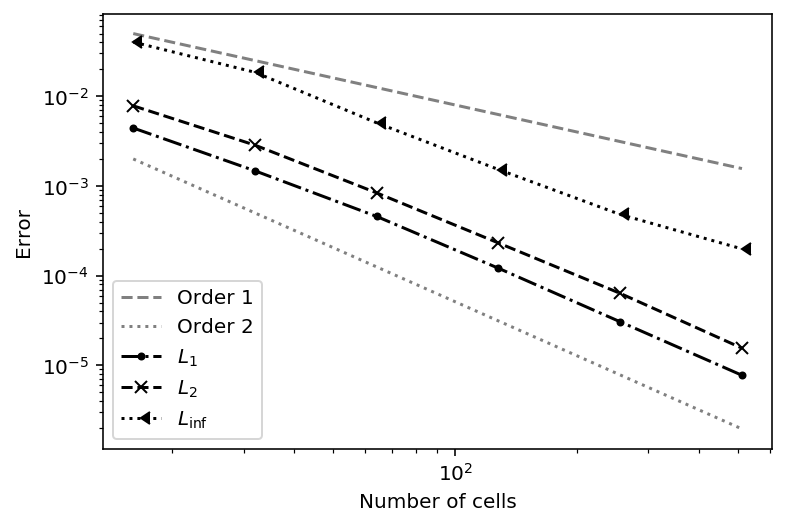

In [14]:
def find_numerical_order(data):
    num_intervals = len(data[0])-1
    order = np.empty(num_intervals)
    for i in range(num_intervals):
        x0 = data[0][i]
        x1 = data[0][i+1]
        y0 = data[1][i]
        y1 = data[1][i+1]
        order[i] = -np.log(y1/y0) / np.log(x1/x0)
        
    return np.median(np.array(order))

fig = plt.figure()
setBwStyles(fig.gca())
#plt.gca().axis('equal')
min_x = domain_min
max_x = domain_max/2
min_scale = 2.0e-3 * min_x * min_x 
max_scale = 5.0e-2 * min_x 
x = np.linspace(min_x, max_x, 4)
plt.loglog(x, max_scale/x, '--', color='gray', label='Order 1')
plt.loglog(x, min_scale/(x*x), ':', color='gray', label='Order 2')

order_str = {1: '$L_1$', 2: "$L_2$", np.inf: "$L_{\inf}$"}


for order in [1, 2, np.inf]:
    cdklm_data = computeError(cdklm_filename, averageFV, order=order)

    plt.loglog(cdklm_data[0], cdklm_data[1], label=order_str[order])
    cdklm_order = find_numerical_order(cdklm_data)
    
    print("------ order " + str(order) + " ----------")
    print("CDKLM: " + str(cdklm_order))

    plt.legend()

    plt.xlabel("Number of cells")
    plt.ylabel("Error")
    
    
l1 = computeError(cdklm_filename, averageFV, order=1)
l2 = computeError(cdklm_filename, averageFV, order=2)
linf = computeError(cdklm_filename, averageFV, order=np.inf)
    
for i in range(len(l1[0])):
    print("${0:d}\\times{0:d}$ & {1:f} & {2:f} & {3:f} \\\\".format(l1[0][i], l1[1][i], l2[1][i], linf[1][i]))
    
    

plt.savefig(imgdir + "/convergence.pdf")    

In [15]:
print(imgdir)

images_convergence_2019_11_05-20_42_12
